In [1]:
import numpy as np
import matplotlib.pyplot as plt
from penrose import Penrose_gen
from BdG import BdG, make_H_kin, correlations, n_avg, fermi, occupation_number
from magnetic_field import *

# Generation of penrose tiling 

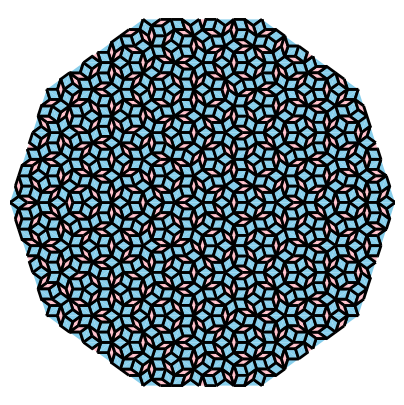

In [3]:
gen = 6

points, triangles = Penrose_gen(gen, plot_tiling = True) 
#points is a list of coordinates of tyles (x, y); 
#triangles is a list of triangles properties (color, a, b, c), where a, b, c are tuples of coordinates of triangle vertices

In [4]:
list_of_nbrs = []
ri = np.array(points)
N = ri.shape[0]
rij = np.array([[rii - rij for rii in ri] for rij in ri])
mrij = np.linalg.norm(rij, axis = -1)
mrij = np.round(mrij, 3)
a = np.unique(mrij)[2]
rij = rij / a
ri = ri / a
nbrs = list(zip(*np.where(mrij == np.unique(mrij)[2])))
list_of_nbrs = [[] for i in range(N)]

for pair in nbrs:
    i, j = pair
    list_of_nbrs[i].append(j)

# Magnetic field properties

In [7]:
# Vector potential 
Ai = np.zeros((N,2))
for i in range(N):
    x, y = ri[i]
    Ai[i] = [-y, 0]

In [8]:
# Vector potential on the ij - link
A0 = np.zeros((N,N,2))
for i in range(N):
    for j in list_of_nbrs[i]:
        A0[i, j] = (Ai[i] + Ai[j]) / 2

In [9]:
nv = 2.1
flux = 2 * np.pi / N
B = flux * nv
Ac = A0 * B

# Setting constants

In [12]:
t = 1.0
g = 2.0 * t
mu = -2.0 * t
T = 0
init_delta = np.exp(1j * np.random.sample(N) * 2 * np.pi)
m = phase_mtx(N, Ac, rij, list_of_nbrs)
M = make_H_kin(N, list_of_nbrs, t)

# Calculations

In [21]:
alpha=0.3
u, v, delta, E = BdG(M, N, list_of_nbrs, mu, g, t, init_delta, m, alpha)

1.6103807669398942
0.10754795798580266
0.030076812959049064
0.00998031366914393
0.005514651498176112
0.00577362009630295
0.007916643717782085
0.00953959470611575
0.0087999658799265
0.007272127684859246
0.005979911356759531
0.004998264193884155
0.004230152698265409
0.0036076374504857155
0.0030915841699350635
0.0026576770157185404
0.002289427535678324
0.001974935555007273
0.001705210514781732
0.0014732140774754243
0.0012732815460012945
0.0011007572299091225
0.0009517552795145083
0.0008229961738048181
0.0007116901784298142
0.0006154509585776014
0.0005322292817266452
0.0004602606312835355
0.00039802282512146133
0.00034420108943674635
0.00029765886679570896
0.00025741315624318816
0.00022261351731121159
0.00019252409065660442
0.00016650813837503577
0.00014401471230152834
0.00012456713452812206
0.00010775303071911888


In [26]:
import pickle
import os

folder_name = f"gen={gen}"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    
file_name = f"gen={gen}/T={T}_g={g}_mu={mu}_nv={nv}"
file_list = [u, v, delta, E]
with open(file_name, "wb") as file:
    pickle.dump(file_list, file)

# Delta $\Delta$ and phase pics

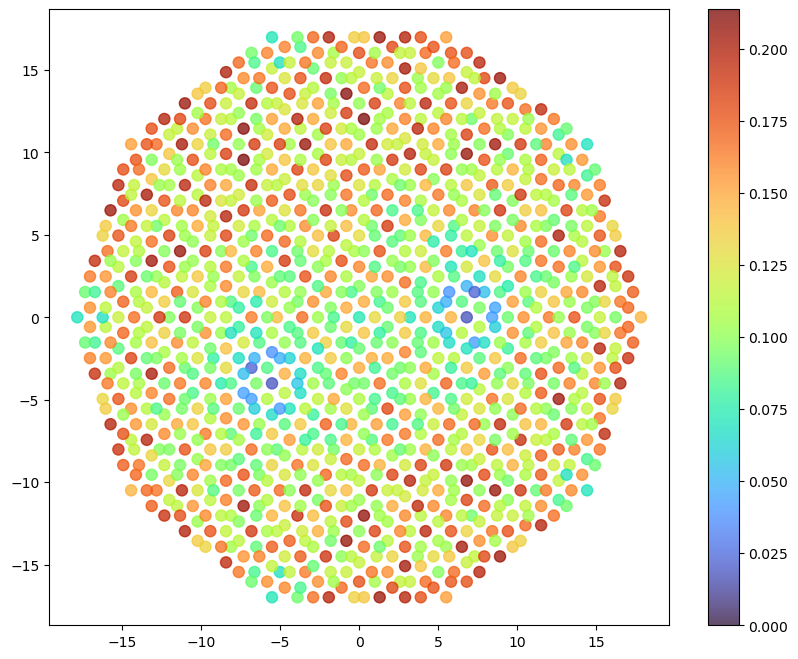

In [35]:
plt.figure(figsize = (10, 8))
plt.scatter(*ri.T, c=abs(delta), cmap = 'turbo', zorder = 1, s = 64, alpha = 0.75, vmin = 0)
plt.colorbar()

In [37]:
phi = np.imag(np.log(delta / abs(delta)))

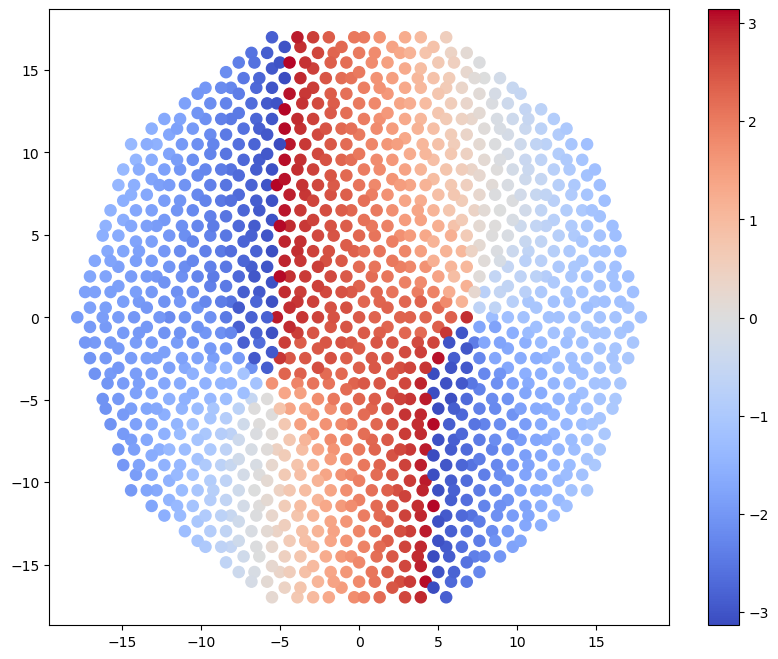

In [41]:
plt.figure(figsize = (10, 8))
plt.scatter(*ri.T, c=phi, cmap='coolwarm', zorder = 1, s = 64)
plt.colorbar()

# Currents

In [48]:
f = fermi(N, E, T)

In [52]:
r0 = 0.5 * np.array([np.array([ri[j] + ri[i] for i in range(N)]) for j in range(N)])

In [53]:
Anew = bio_sav(u, v, N, Ac, M, rij, list_of_nbrs, E, r0, ri)
A = Anew
A0i = Ac + A
H0 = M * phase_mtx(N, A0i, rij, list_of_nbrs)

In [56]:
J = current(u, v, H0, f, list_of_nbrs, N, T=0)
J = J.real
J = J / J.max()
J[J < 0.1] = 0

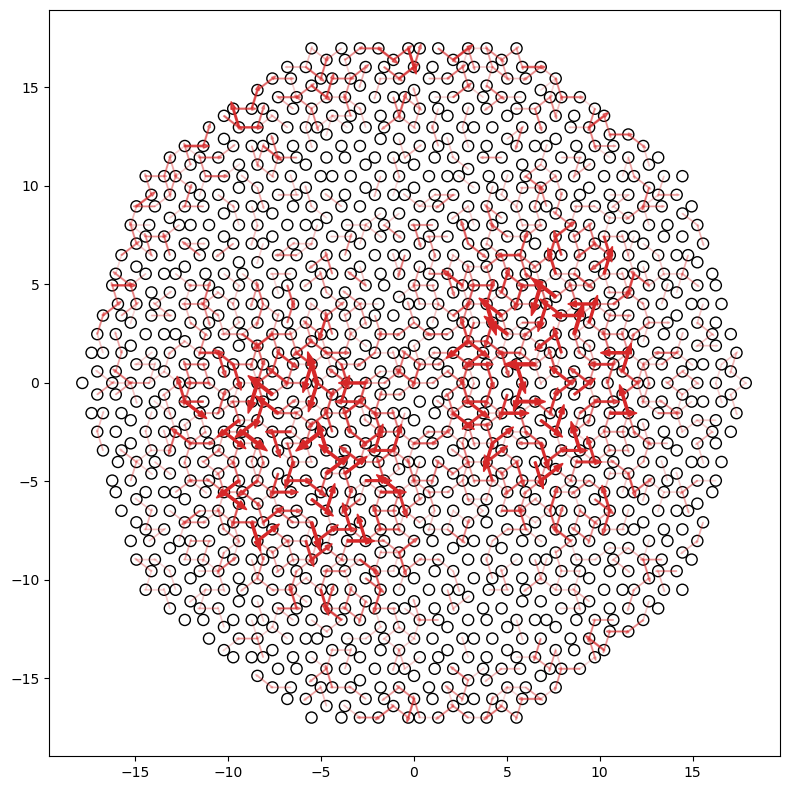

In [62]:
plt.figure(figsize = (8, 8))
plt.scatter(*np.array(ri).T, c = 'None',  s = 64, edgecolor = 'black')
for i in range(N):
    for j in list_of_nbrs[i]:
        if J[i,j] > 0:
            x,y = ri[i]
            xn,yn = ri[j]
            dx, dy = xn - x, yn - y 
            plt.arrow(x, y, dx, dy, width = 0.15 * J[i,j], alpha = np.min([1.5 * J[i,j], 1]), color = 'tab:red')
plt.tight_layout()

# Magnetic field pics

In [96]:
points = np.array(points)

In [98]:
elements = []
for triangle in triangles:
    xa, ya = triangle[1]
    xb, yb = triangle[2]
    xc, yc = triangle[3]
    a = np.where((points[:,0] == xa) & (points[:,1] == ya))[0][0]
    b = np.where((points[:,0] == xb) & (points[:,1] == yb))[0][0]
    c = np.where((points[:,0] == xc) & (points[:,1] == yc))[0][0]
    elements.append([a,b,c])

In [100]:
maze = []
for el in elements:
    a, b, c = el
    nbr1 = set(list_of_nbrs[a])
    nbr2 = set(list_of_nbrs[c])
    s = nbr1.intersection(nbr2)
    d = s.pop()
    if d != b:
        maze.append((a,b,c,d))
    else:
        if s:
            d = s.pop()
            maze.append((a,b,c,d))

In [112]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

(-19.642857142857146,
 19.642857142857146,
 -18.681467284369088,
 18.681467284369088)

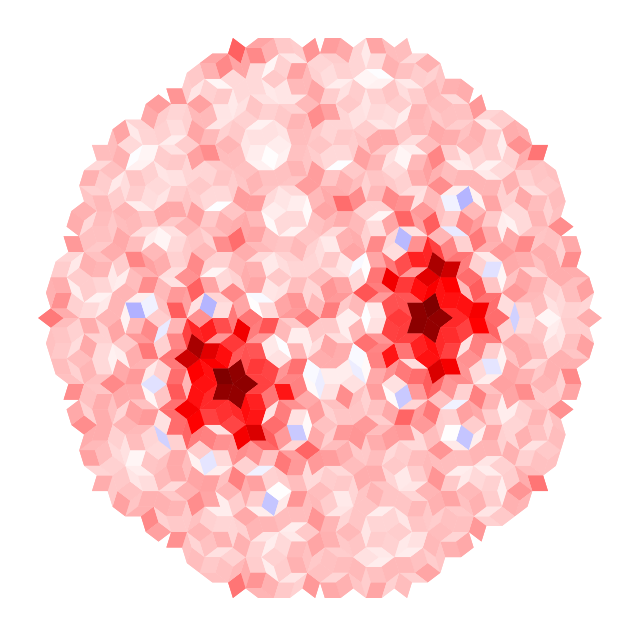

In [122]:
fig, ax = plt.subplots(1, 1, figsize = (8,8))
patches = []
colors = []
for el in maze:
    coords = ri[el, :]
    polygon = Polygon(coords, facecolor = 'red', edgecolor = 'black')
    patches.append(polygon)
    a, b, c, d = el
    r1 = rij[a, b]
    r2 = rij[b, c]
    r1r2 = (r1[0] * r2[1] - r1[1] * r2[0])
    sign = np.sign(r1r2)
    Bi = A0i[a,b] @ rij[a,b] + A0i[b,c] @ rij[b,c] + A0i[c,d] @ rij[c,d] + A0i[d,a] @ rij[d,a]
    colors.append(sign * Bi.real)

p = PatchCollection(patches, alpha=1, cmap = 'seismic')
p.set_array(colors)
p.set_clim(vmin=-np.max(colors), vmax=np.max(colors))
ax.add_collection(p)

ax.set_xlim(ri[:,0].min()*1.1, ri[:,0].max()*1.1);
ax.set_ylim(ri[:,1].min()*1.1, ri[:,1].max()*1.1);

fig.patch.set_visible(False)
ax.axis('off')